# Long Trace PRF - Forward Simulation
Here I have created a short demonstration of neuron behaviour under influence of a long trace stimulus history effect (i.e. adaptation).  The idea of this long trace model was adopted from:

+ Fritsche, M., Solomon, S. G., & de Lange, F. P. (2021). Brief stimuli cast a long-term trace in visual cortex. bioRxiv.

Models are implemented for auditory perception, but since this is a toy simulation can easily be adopted to nearly all neuron prefferences.

In [212]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

import scipy.stats as stats

## Step 1: simple forward model
+ Using just 2 neurons
+ Presented stimuli either:
  + Preffered
  + Ortogonal

In [213]:
def Log_trans(x):
    return( np.log10(x) )

def Exp_trans(x):
    return( 10**x)

In [214]:
logtransform_freq = True   # if true, log transform frequencies

# stimulus presentation
stim_train_length = 1000   # number of presented stimuli
stim_train_options = [100, 1000] # presented stimuli options

# tuning curve sim
tuning_stepsize = 0.05      # x_size of the gaussian
tuning_lim      = [0, 4]   # the bounds of the gaussian
# HIER GEBLEVEN

# tuning behaviour neuron 1
neuron_1_tun_pref = 1000  # preference in hz
neuron_1_tun_peak = 1      # peak activity (1 for simplicity)
neuron_1_tun_shrp = 0.25    # sharpness of the tuning function

# tuning behaviour neuron 2
neuron_2_tun_pref = 100    # preference in hz
neuron_2_tun_peak = 1      # peak activity (1 for simplicity)
neuron_2_tun_shrp = 0.25    # sharpness of the tuning function

# log transform from Hz range to log(hz)
if logtransform_freq:
    stim_train_options = Log_trans(stim_train_options)
    neuron_1_tun_pref  = Log_trans(neuron_1_tun_pref)
    neuron_2_tun_pref  = Log_trans(neuron_2_tun_pref)

# create the stimulus train
stim_train = np.random.randint(2, size=stim_train_length)
for i in range(0,len(stim_train_options)):
    stim_train[stim_train == i] = stim_train_options[i]
    
## NOTE: LATER WE CAN CREATE ONE BIG MATRIX OR DATAFRAME FOR PARAMETERS OF MANY NEURONS
##       THE CODE SHOULD ALLOW TO EASILY SCALE THIS OP (SEE FURTHER)

### Defining our neuron tuning behaviour

For each neuron we define excitability preferences by the Gaussian Function:

$f(x) = a * exp^{(-\frac{(x-b)^2}{2c^2})}$

where:
+ $a$: Is the peak firing rate - or top of the Gaussian
+ $b$: Is the tuning preference
+ $c$: Is the sharpness / broadness of the Gaussian

and:
+ $f(x)$: Is the firing rate (*or other notation of activity*) for all inputs x (*here a presented frequency*) [with maximum $a$].

-------------------------------
We may assume that tuning for frequency is behaving on the $log$ scale

In [215]:
def Gaussian_func(tun_pref, tun_sharp, xlims, stepsize, tun_peak=1):
    """input parameters of gaussian function
    input:  tun_pref=tuning prefference
            tun_sharp=tuning sharpness
            xlim=bounds of tuning
            stepsize=step size of x
    optional in: tun_peak=the peak of the tuning
    output: return np.array for x and y
    """
    # define x and y arrays
    return_x = np.arange(xlims[0], xlims[1]+stepsize, stepsize)
    return_y = np.zeros(return_x.shape[0])
    
    # get y value for each step x
    for x in range(return_x.shape[0]):
        return_y[x] = Gaussian_point(tun_pref, tun_sharp, return_x[x], tun_peak=tun_peak)

    return(return_x, return_y) # return x and y array

def Gaussian_point(tun_pref, tun_sharp, x, tun_peak=1):
    """Get y / hight on gaussian for a certain x
    input: tun_pref=tuning prefference
           tun_sharp=tuning sharpness
           x=x to calculate
    return: y value for that x"""
    return(tun_peak * np.exp(-((x-tun_pref)**2)/(2*tun_sharp**2)))

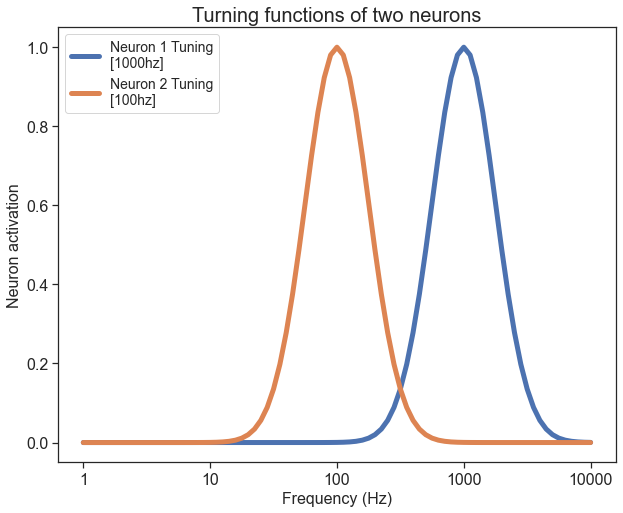

In [216]:
neuron1_x, neuron1_y = Gaussian_func(neuron_1_tun_pref, neuron_1_tun_shrp, tuning_lim, tuning_stepsize)
neuron2_x, neuron2_y = Gaussian_func(neuron_2_tun_pref, neuron_2_tun_shrp, tuning_lim, tuning_stepsize)

figsize(10, 8)
sns.set_theme(style="ticks")

# create lineplots for both tuning functions
g = sns.lineplot(x=neuron1_x, 
                 y=neuron1_y, 
                 label='Neuron 1 Tuning\n[{}hz]'.format(int(Exp_trans(neuron_1_tun_pref))),
                 lw=5)
g = sns.lineplot(x=neuron2_x, 
                 y=neuron2_y, 
                 label='Neuron 2 Tuning\n[{}hz]'.format(int(Exp_trans(neuron_2_tun_pref))),
                 lw=5)
plt.xticks(neuron1_x[::round(len(neuron1_x)/tuning_lim[1])], 
           Exp_trans(neuron1_x)[::round(len(neuron1_x)/tuning_lim[1])].astype(int));

plt.title("Turning functions of two neurons", fontsize=20)
plt.ylabel("Neuron activation", fontsize=16)
plt.xlabel("Frequency (Hz)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="upper left", fontsize=14);

### Adaptation decays by stimulus history
Here we use the formula:
$f(n) = 1 - a_{fast} * exp^{(-\frac{n-1}{t_{fast}})} - a_{slow} * exp^{(-\frac{n-1}{t_{slow}})}$
Where:
+ $n$: is the number of trials back (stimulus history)
+ $a_{fast}$: magnitude of fast adaptation component
+ $t_{fast}$: recovery time of fast adaptation component
+ $a_{fast}$: magnitude of slow adaptation component
+ $t_{fast}$: recovery time of slow adaptation component

In [217]:
def Double_exp_decay_func(afast, tfast, aslow, tslow, xlims, stepsize):
    """input parameters of double exponential decay and returns and x and y array
    input:  afast: magnitude of fast adaptation
            tfast: recovery of fast adaptation
            aslow: magnitde of slow adaptation
            tslow: recovery of slow adaptation
    output: return np.array for x and y
    """
    # define x and y arrays
    return_x = np.arange(xlims[0], xlims[1]+stepsize, stepsize)
    return_y = np.zeros(return_x.shape[0])
    
    # get y value for each step x
    for x in range(return_x.shape[0]):
        return_y[x] = 1 - (afast * np.exp(-(return_x[x]-1)/tfast)) - (aslow * np.exp(-(return_x[x]-1)/tslow))
    
    return(return_x, return_y) # return x and y array

In [218]:
# set parameters for double exp decay
afast = 0.1399 
tfast = 0.85
aslow = 0.0345
tslow = 6.82

# set bounds and stepsize
decay_bounds = [1,6]
decay_stepsize = 1   # because we are interested in stimuli, keep this on 1

# get decay arrays
x_decay, y_decay = Double_exp_decay_func(afast, tfast, aslow, tslow, decay_bounds, decay_stepsize)

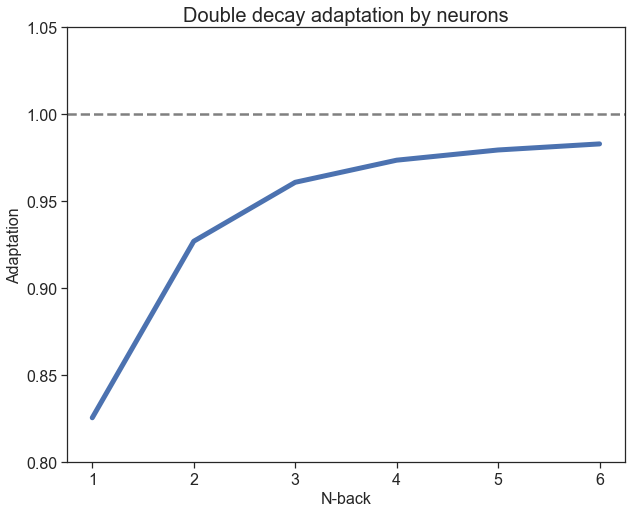

In [219]:
figsize(10, 8)
sns.set_theme(style="ticks")

# create lineplots for both tuning functions
g = sns.lineplot(x=x_decay, 
                 y=y_decay, 
                 lw=5)

plt.title("Double decay adaptation by neurons", fontsize=20)
plt.ylabel("Adaptation", fontsize=16)
plt.xlabel("N-back", fontsize=16)
plt.axhline(1, color='grey', lw=2.5, ls='--')
plt.ylim([0.80, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

## Off to the the races 🐎 - loop over the stimulus set
For now we take only 6 N-backs, to keep things simple

In [9]:
def Stim_adaptation(stim_train, y_decay):
    """Input a stimulus train of some length and n-back decay array,
    then return per stimulus adaptation (multiplicative and full array)
    input: stim_train: the n long stim train
           y_decay: n-back array from decay function
    returns: total_adapt: multiplicative adaptation per stim [length stim train]
             adapt_matrix: complete adaptation matrix [length stim train  *  number of N-backs]"""

    adapt_matrix = np.zeros([len(stim_train), len(y_decay)])   # make empty matrix of train length by number of N-backs 
    total_adapt = np.zeros(len(stim_train))                    # make empty array of stim train length

    # loop over stimuli starting at N+1
    for stim in range(0, len(stim_train)):

        # create a temp nback array to indicate adoptation
        n_back_array = np.zeros(len(y_decay))

        # for the first few stimulus (to avoid wrapping)
        if stim <= len(y_decay): 
            # populate Nback array with boolean, starting from right most (n-1)
            n_back_array[:stim] = (stim_train[:stim] == stim_train[stim]).astype(int)[::-1]

        else: 
            # populate Nback array with boolean, starting from right most (n-1)
            n_back_array[:] = (stim_train[stim-len(y_decay):stim] == stim_train[stim]).astype(int)[::-1]

        # populate our return arrays
        n_back_array *= y_decay                                      # multiply boolean array by decay array (1 encoding) 
        adapt_matrix[stim,:] = n_back_array                          # full length by N-backs array
        total_adapt[stim] = np.prod(n_back_array[n_back_array > 0])  # multiplicative adaptation
        
#         if n_back_array.sum() > 0: total_adapt[stim] = np.prod(n_back_array[n_back_array > 0])  # multiplicative adaptation
#         else: total_adapt[stim]: 0.0

    return(total_adapt, adapt_matrix)

In [10]:
adapt_total, adapt_matrix = Stim_adaptation(stim_train, y_decay)

<IPython.core.display.Javascript object>


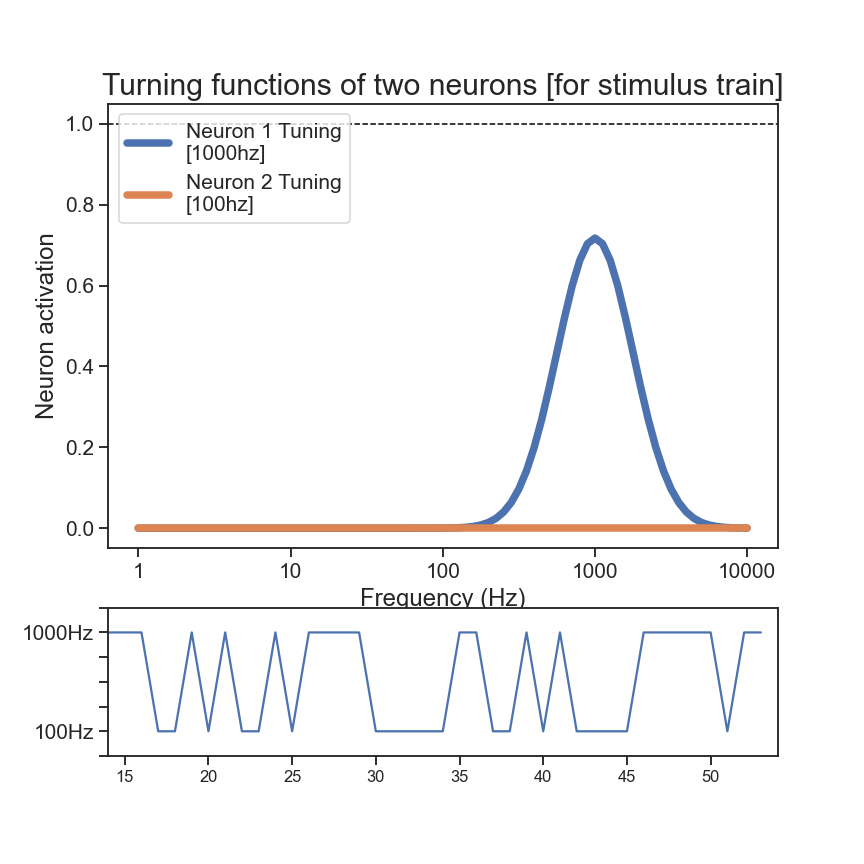

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# get base tuning curve
neuron1_x, neuron1_y = Gaussian_func(neuron_1_tun_pref, neuron_1_tun_shrp, tuning_lim, tuning_stepsize)
neuron2_x, neuron2_y = Gaussian_func(neuron_2_tun_pref, neuron_2_tun_shrp, tuning_lim, tuning_stepsize)

# set when new activation happens
adapt_total_n1 = (stim_train == neuron_1_tun_pref).astype(int) * adapt_total
adapt_total_n2 = (stim_train == neuron_2_tun_pref).astype(int) * adapt_total

# constants and x array
length = len(stim_train)

# create figure and axes 
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]})

# creating our line objects for the plots
n1, = ax1.plot(neuron1_x, neuron1_y, 
               label='Neuron 1 Tuning\n[{}hz]'.format(int(Exp_trans(neuron_1_tun_pref))),
               lw=5)
n2, = ax1.plot(neuron2_x, neuron2_y, 
               label='Neuron 2 Tuning\n[{}hz]'.format(int(Exp_trans(neuron_2_tun_pref))),
               lw=5)

# stimuli presentation plot
stim, = ax2.plot(stim_train[0])

def animate(B):
    """
    this function gets called by FuncAnimation
    each time called, it will replot with a different tuning peak "B"
    """
    
    # create our neuron 1 tuning func
    n1.set_ydata(Gaussian_func(neuron_1_tun_pref, 
                               neuron_1_tun_shrp, 
                               tuning_lim, 
                               tuning_stepsize, 
                               tun_peak=adapt_total_n1[B])[1])
    
    # create our neuron 2 tuning func
    n2.set_ydata(Gaussian_func(neuron_2_tun_pref, 
                               neuron_2_tun_shrp, 
                               tuning_lim, 
                               tuning_stepsize, 
                               tun_peak=adapt_total_n2[B])[1])
    
    # and for stimulus presentation
    if B < 40:
        stim.set_xdata(steps[0:B])
        stim.set_ydata(stim_train[0:B])
        ax2.set_xlim(0, B)
    else:
        stim.set_xdata(steps[B-40:B])
        stim.set_ydata(stim_train[B-40:B])    
        ax2.set_xlim(B-40, B)

    
    
def init():
    """
    initialize the figure
    """
    # set horizontal line for 'default' activation
    ax1.axhline(1, color='black', lw=1, ls='--')
    
    # set xtick dimension
    ax1.set_xticks(neuron1_x[::round(len(neuron1_x)/tuning_lim[1])])
    ax1.set_xticklabels(Exp_trans(neuron1_x)[::round(len(neuron1_x)/tuning_lim[1])].astype(int), fontsize=14)
    ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=14)
    
    # set text
    ax1.legend(loc="upper left", fontsize=14);
    ax1.set_title("Turning functions of two neurons [for stimulus train]", fontsize=20)
    ax1.set_ylabel("Neuron activation", fontsize=16)
    ax1.set_xlabel("Frequency (Hz)", fontsize=16)
    
    # set y ticks for 2nd graph
    ax2.set_yticks(np.arange(stim_train.min()-0.25, stim_train.max()+0.5, 0.25))
    ax2.set_yticklabels(['','100Hz','','','','1000Hz',''], fontsize=14)
    
    return n1, n2, stim

steps = np.arange(0, len(stim_train))
ani = FuncAnimation(fig, animate, steps, init_func=init, interval=50, blit=False)
plt.show()

### Lets look at a toy sequences that are less random [3X100hz, 3x1000hz repeating]

<IPython.core.display.Javascript object>


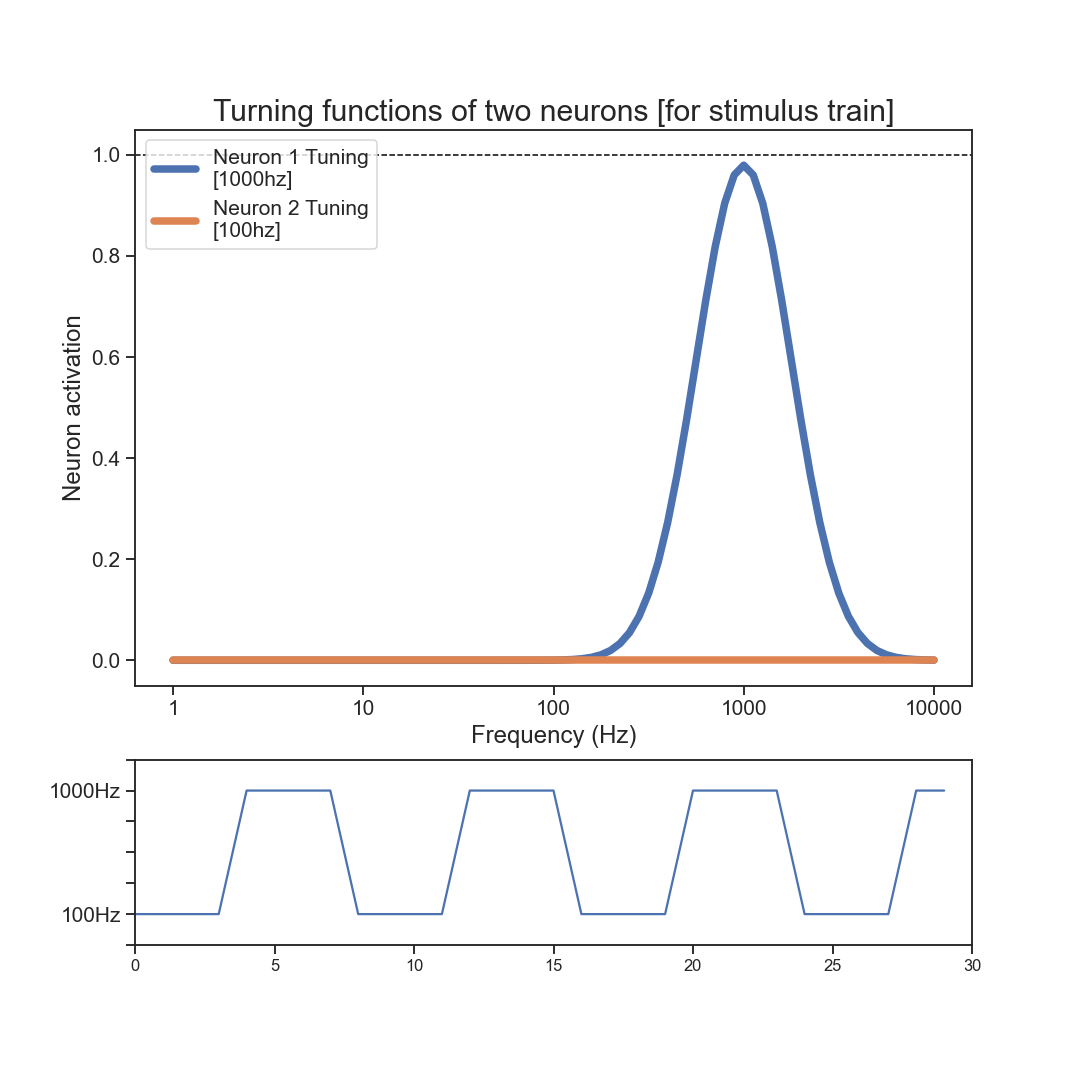

In [12]:
# make new sequence
stim_train_2 = np.tile(([2] * 4) + ([3] * 4), 125)

# get base tuning curve
neuron1_x, neuron1_y = Gaussian_func(neuron_1_tun_pref, neuron_1_tun_shrp, tuning_lim, tuning_stepsize)
neuron2_x, neuron2_y = Gaussian_func(neuron_2_tun_pref, neuron_2_tun_shrp, tuning_lim, tuning_stepsize)

# set when new activation happens
adapt_total_n1 = (stim_train_2 == neuron_1_tun_pref).astype(int) * adapt_total
adapt_total_n2 = (stim_train_2 == neuron_2_tun_pref).astype(int) * adapt_total

# constants and x array
length = len(stim_train_2)

# create figure and axes 
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})

# creating our line objects for the plots
n1, = ax1.plot(neuron1_x, neuron1_y, 
               label='Neuron 1 Tuning\n[{}hz]'.format(int(Exp_trans(neuron_1_tun_pref))),
               lw=5)
n2, = ax1.plot(neuron2_x, neuron2_y, 
               label='Neuron 2 Tuning\n[{}hz]'.format(int(Exp_trans(neuron_2_tun_pref))),
               lw=5)

def animate(B):
    """
    this function gets called by FuncAnimation
    each time called, it will replot with a different tuning peak "B"
    """
    
    # create our neuron 1 tuning func
    n1.set_ydata(Gaussian_func(neuron_1_tun_pref, 
                               neuron_1_tun_shrp, 
                               tuning_lim, 
                               tuning_stepsize, 
                               tun_peak=adapt_total_n1[B])[1])
    
    # create our neuron 2 tuning func
    n2.set_ydata(Gaussian_func(neuron_2_tun_pref, 
                               neuron_2_tun_shrp, 
                               tuning_lim, 
                               tuning_stepsize, 
                               tun_peak=adapt_total_n2[B])[1])
    
    # and for stimulus presentation
    if B < 40:
        stim.set_xdata(steps[0:B])
        stim.set_ydata(stim_train_2[0:B])
        ax2.set_xlim(0, B)
    else:
        stim.set_xdata(steps[B-40:B])
        stim.set_ydata(stim_train_2[B-40:B])    
        ax2.set_xlim(B-40, B)

# stimuli presentation plot
stim, = ax2.plot(stim_train_2[0])


steps = np.arange(0, len(stim_train_2))
ani = FuncAnimation(fig, animate, steps, init_func=init, interval=200, blit=False)
plt.show()

<IPython.core.display.Javascript object>


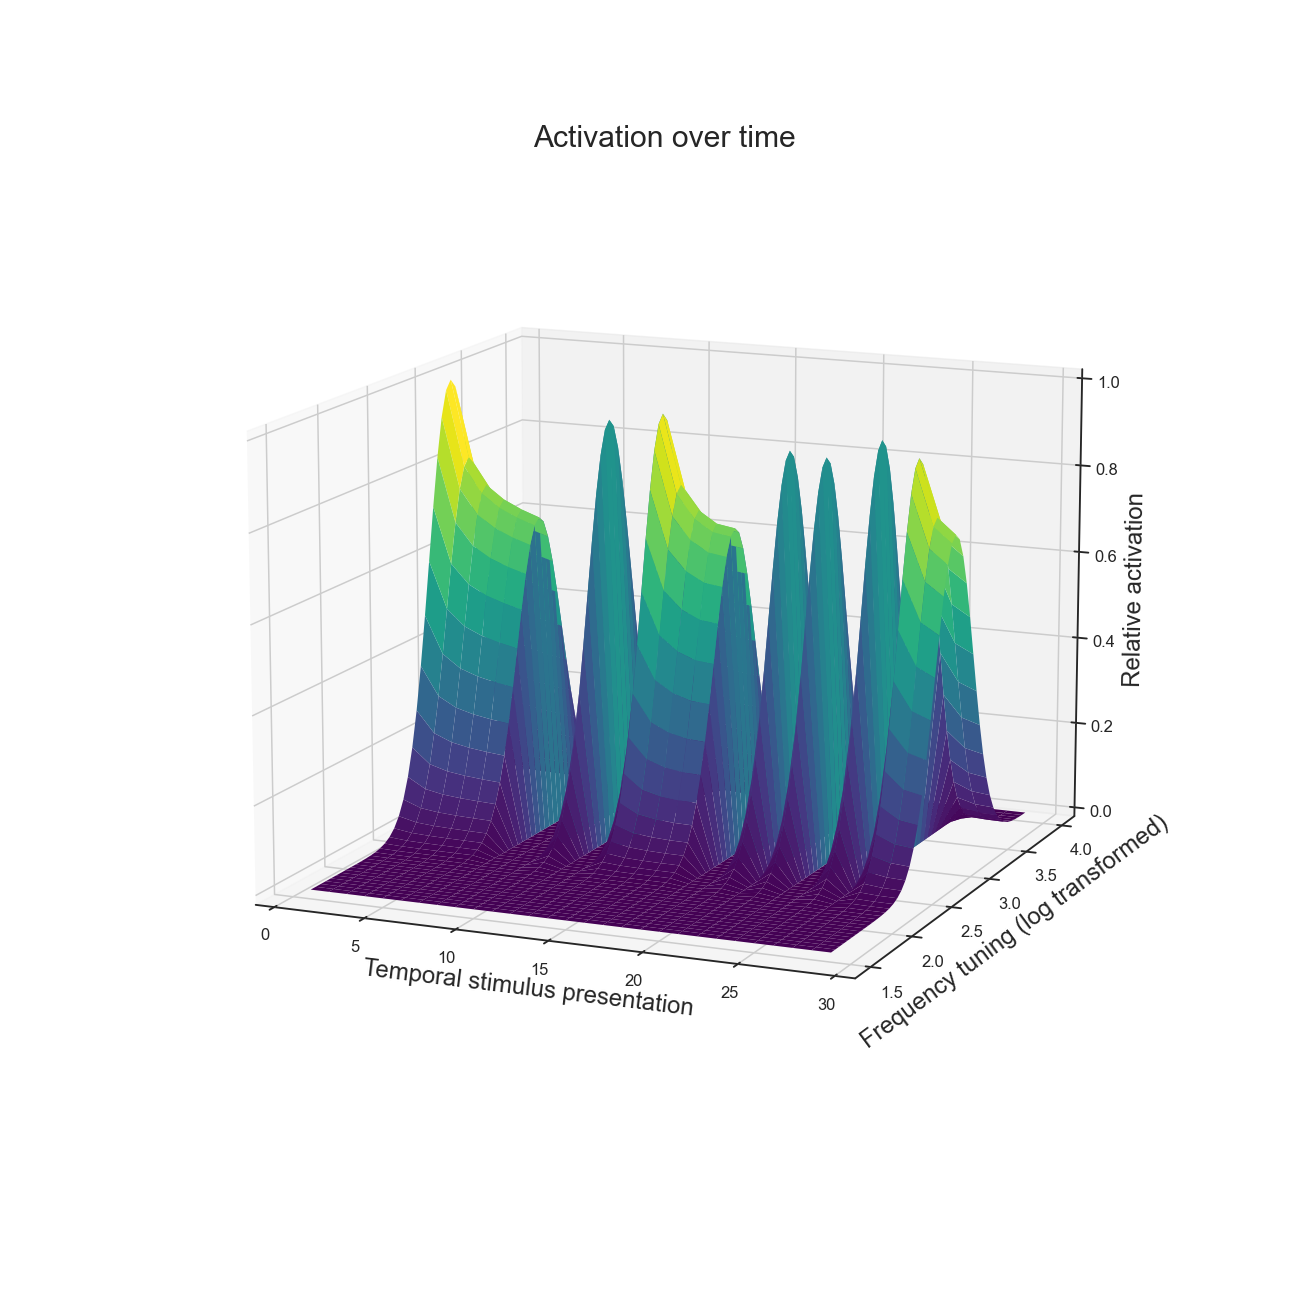

In [13]:
neuron1_x, neuron1_y = Gaussian_func(neuron_1_tun_pref, neuron_1_tun_shrp, tuning_lim, tuning_stepsize)

y = neuron1_x[30:]           # the size of our tuning function
x = np.arange(1, 30)   # our temporal component

X, Y = np.meshgrid(x,y)

adapt_total, adapt_matrix = Stim_adaptation(stim_train, y_decay)
adapt_total_n1 = (stim_train == neuron_1_tun_pref).astype(int) * adapt_total

Z = np.zeros(X.shape)

for i in range(len(Z[0,:])):
    x, y = Gaussian_func(neuron_1_tun_pref, neuron_1_tun_shrp, tuning_lim, tuning_stepsize, tun_peak=adapt_total_n1[i])
    Z[:,i] = y[30:]
    
figsize(12, 12)
    
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Activation over time', fontsize=20)
ax.set_xlabel("Temporal stimulus presentation", fontsize=16)
ax.set_ylabel("Frequency tuning (log transformed)", fontsize=16)
ax.set_ylabel("Frequency tuning (log transformed)", fontsize=16)
ax.set_zlabel("Relative activation", fontsize=16);

## However...
Modelling adaptation statically by using N-x trails and using this multiplicative result for next stimulation seems inefficient (and not tractible if we consider N-all past events).
+ We can get to the same results if we model the adaptation itself as a decaying function
+ Where the decay is only dependent on the residual decay and the last activation

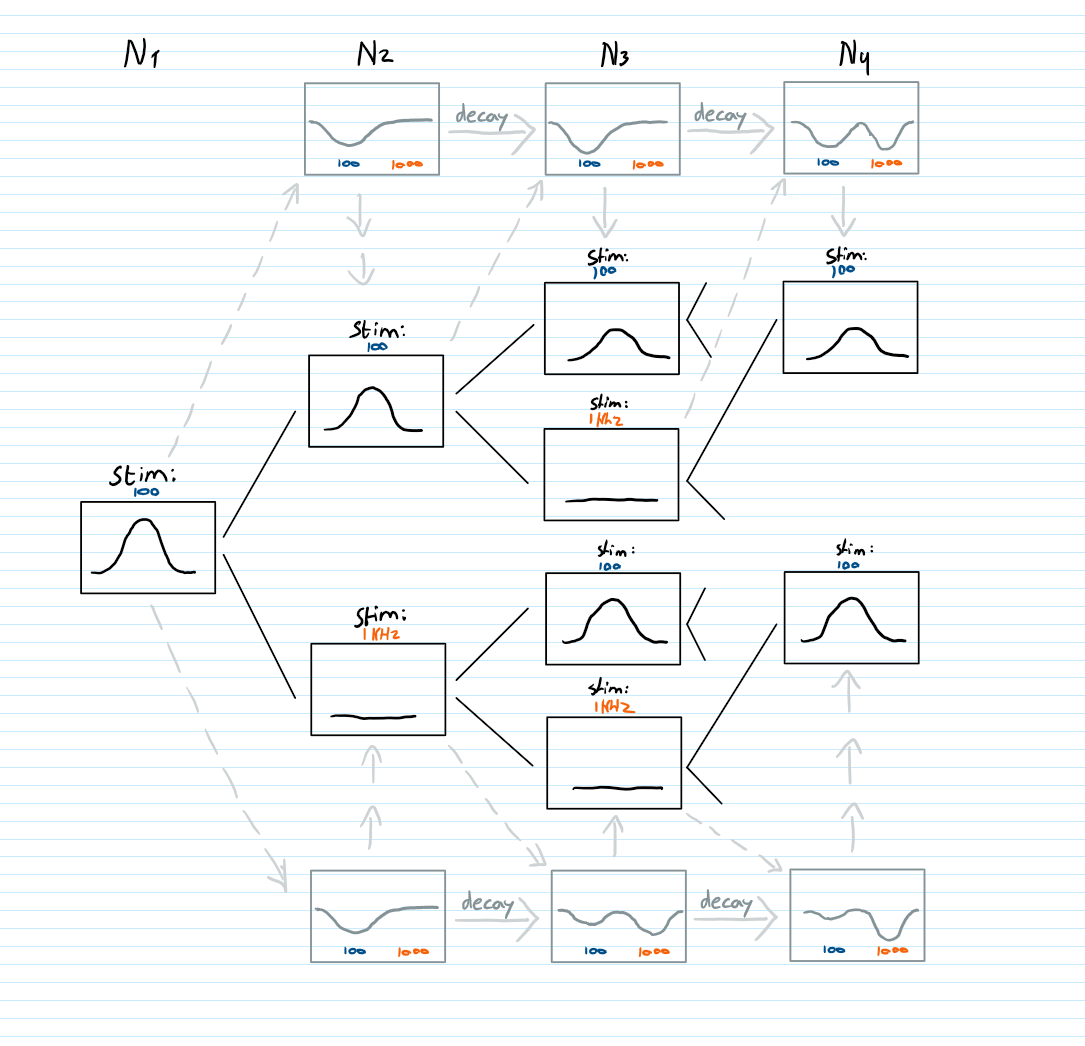

Note: that we can do this because we assume that adaptation is dependent on previous activation.
+ presenting an adoptation function landscape
+ however, if adaptation works by a threshold (only adoptation at x> activation) - then this landscape will behave differently

In [136]:
# set parameters for double exp decay
afast = 0.1399 
tfast = 0.85
aslow = 0.0345
tslow = 6.82

# pre create our arrays
n_1_adaptation = np.empty(2)
res_adaptation = np.zeros(2)
adaptation = np.zeros(2)
a = [afast, aslow]
t = [tfast, tslow]

In [109]:
activations = [1, 0, 0]

for activation in activations:

    # loop over the kinds of adaptation (in this case just fast and slow but can be expended)
    # ([0] = fast, [1] = slow)
    for i in range(len(n_1_adaptation)):

        # set new adaptation and decay residual adaptation
        n_1_adaptation[i] = activation * a[i]
        res_adaptation[i] = adaptation[i] * np.exp(-(1/t[i]))

        # add new to decayed residual adaptation
        adaptation[i] = n_1_adaptation[i] + res_adaptation[i] 

#### You can see that the residual adaptation by this step function (ABB) is identical to the one calculated by the double exp decay function

In [151]:
print("Exponential decay function: {0:.3g}\nStep function: {0:.3g}".format(y_decay[2], 1-adaptation.sum()))

Exponential decay function: 0.961
Step function: 0.961


#### Wrap it in a function

In [238]:
def Decay_step(activation, a, t, res_adaptation, exp_explosion=0.99):
    
    # Small check to reset res decay if it goes above 98,5% 
    # This is not necesarry but, for long chains (in the limit) any kind of activation would be impossible
    if exp_explosion != False:
        if (1-res_adaptation.sum()) > exp_explosion: res_adaptation = np.zeros(2)
    
    # set empty array for N-1 adaptation
    n_1_adaptation = np.zeros(len(a))
    adaptation = np.zeros(len(a))
    
    # loop over the kinds of adaptation (in this case just fast and slow but can be expended)
    # ([0] = fast, [1] = slow)
    for i in range(len(a)):

        # set new adaptation and decay residual adaptation
        n_1_adaptation[i] = activation * a[i]                       # calculate n-1 adaptation
        res_adaptation[i] = res_adaptation[i] * np.exp(-(1/t[i]))   # decay prev residual

        # add new to decayed residual adaptation
        adaptation[i] = n_1_adaptation[i] + res_adaptation[i]       # add current n-1 decay
        
    return(adaptation)

In [199]:

adapt, res = Decay_step(1, [afast, aslow], [tfast, tslow], np.zeros(2))

for i in range(15):
    adapt, res = Decay_step(0, [afast, aslow], [tfast, tslow], adapt)


In [285]:
Decay_step(1, [afast, aslow], [tfast, tslow], np.zeros(2))

array([0.1399, 0.0345])

### For now, we still use our two neurons, that are tuned exactly on the stimuli
This means we dont need to calculate the gaussian point hight for the input stimuli, since in this toy example where the stim are based on the tuning.

In [265]:
neuron1_bool = (stim_train == neuron_1_tun_pref).astype(int)
neuron2_bool = (stim_train == neuron_2_tun_pref).astype(int)

# crete adaptation for neurons
adaptation_neuron1 = np.zeros([2, len(stim_train)])
adaptation_neuron2 = np.zeros([2, len(stim_train)])

for i in range(1, len(stim_train)):
    
    # check new adaptation
    adaptation_neuron1[:,i] = Decay_step(neuron1_bool[i], [afast, aslow], [tfast, tslow], adaptation_neuron1[:,i-1])
    adaptation_neuron2[:,i] = Decay_step(neuron2_bool[i], [afast, aslow], [tfast, tslow], adaptation_neuron2[:,i-1])

# substract from 1 to translate from relative adaptation to absolute
adaptation_neuron1 = 1- adaptation_neuron1.sum(axis=0)
adaptation_neuron2 = 1- adaptation_neuron2.sum(axis=0)

# calculate activity of neuron
activation_neuron1 = adaptation_neuron1 * neuron1_bool
activation_neuron2 = adaptation_neuron2 * neuron2_bool

### Plot results for neuron 1
+ As you may notice: results are identical to the top of the 3d plot before

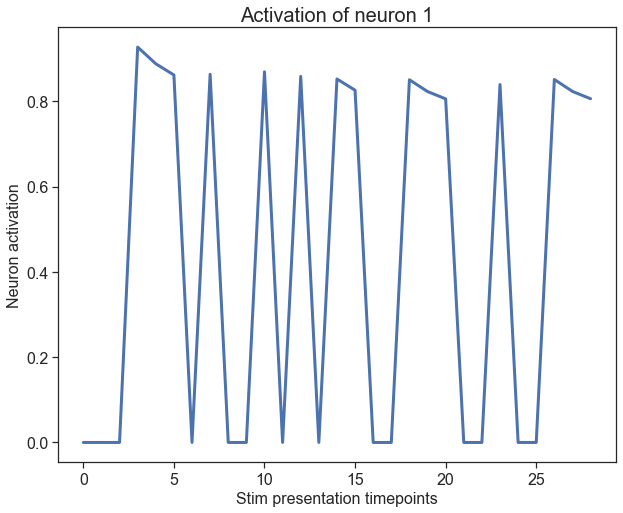

In [272]:
x = np.arange(1, 30)
y_1 = activation_neuron1

plt.plot(activation_neuron1[:len(x)], label="Neuron 1", lw=3)
# plt.plot(activation_neuron2[:len(x)], label="Neuron 2")

plt.title("Activation of neuron 1", fontsize=20)
plt.ylabel("Neuron activation", fontsize=16)
plt.xlabel("Stim presentation timepoints", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);
# plt.legend(loc="upper left", fontsize=14);

In [ ]:
# Next we look at many different stimuli but stil the neuron1 (and maybe neuron 2) case
# - here the activation is not a boolean, but proportional to the gaussian point thingy

In [278]:
random_stim_train = np.random.uniform(1,4,len(stim_train))  # create new stim train (uniform random between log1-4hz)

In [296]:
# neuron1_bool = (stim_train == neuron_1_tun_pref).astype(int)
# neuron2_bool = (stim_train == neuron_2_tun_pref).astype(int)

# crete adaptation for neurons
adaptation_neuron1 = np.zeros([2, len(random_stim_train)])
adaptation_neuron2 = np.zeros([2, len(random_stim_train)])

stim_activation_n1 = np.zeros(len(random_stim_train))
stim_activation_n2 = np.zeros(len(random_stim_train))
stim_activation_n1[0] = Gaussian_point(neuron_1_tun_pref, neuron_1_tun_shrp, random_stim_train[0])
stim_activation_n2[0] = Gaussian_point(neuron_2_tun_pref, neuron_2_tun_shrp, random_stim_train[0])

for i in range(1, len(random_stim_train)):
    
    # calculate the current activation for the current stimulus
    stim_activation_n1[i] = Gaussian_point(neuron_1_tun_pref, neuron_1_tun_shrp, random_stim_train[i])
    stim_activation_n2[i] = Gaussian_point(neuron_2_tun_pref, neuron_2_tun_shrp, random_stim_train[i])
    
    # check new adaptation
    adaptation_neuron1[:,i] = Decay_step(stim_activation_n1[i], 
                                         [afast, aslow], 
                                         [tfast, tslow], 
                                         adaptation_neuron1[:,i-1])
    adaptation_neuron2[:,i] = Decay_step(stim_activation_n2[i], 
                                         [afast, aslow], 
                                         [tfast, tslow], 
                                         adaptation_neuron2[:,i-1])

# substract from 1 to translate from relative adaptation to absolute
adaptation_neuron1 = 1- adaptation_neuron1.sum(axis=0)
adaptation_neuron2 = 1- adaptation_neuron2.sum(axis=0)

# calculate activity of neuron
activation_neuron1 = adaptation_neuron1 * stim_activation_n1
activation_neuron2 = adaptation_neuron2 * stim_activation_n2

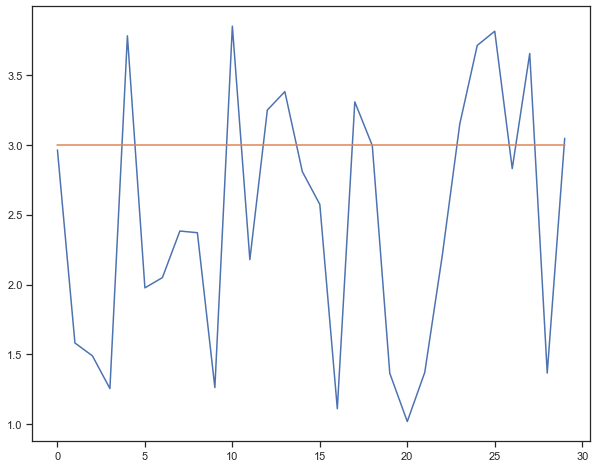

In [297]:
plt.plot(random_stim_train[:30])
plt.plot([neuron_1_tun_pref] * 30)

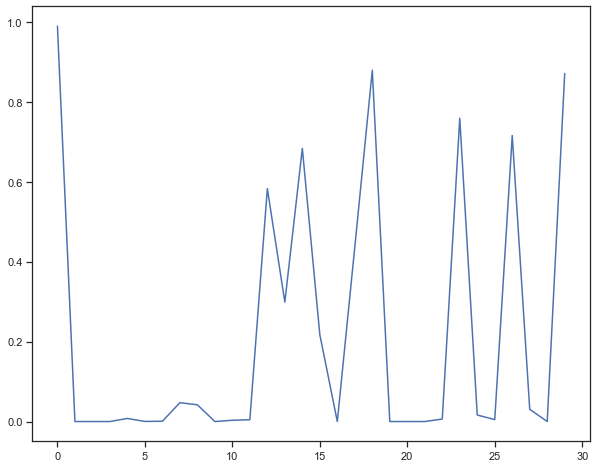

In [298]:
plt.plot(activation_neuron1[:30])

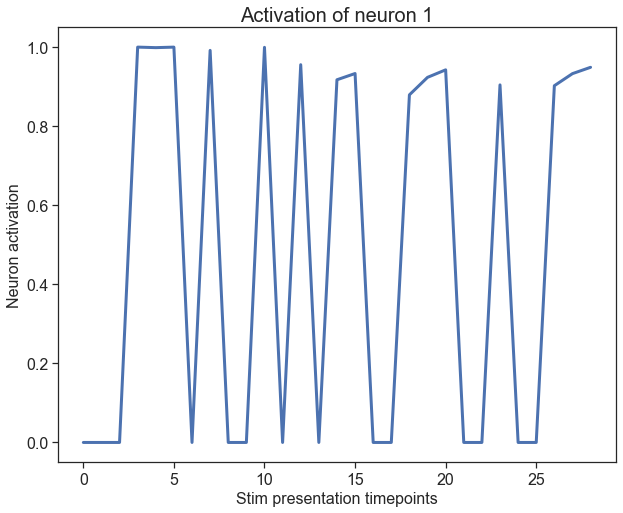

In [288]:
x = np.arange(1, 30)
y_1 = activation_neuron1

plt.plot(activation_neuron1[:len(x)], label="Neuron 1", lw=3)
# plt.plot(activation_neuron2[:len(x)], label="Neuron 2")

plt.title("Activation of neuron 1", fontsize=20)
plt.ylabel("Neuron activation", fontsize=16)
plt.xlabel("Stim presentation timepoints", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);
# plt.legend(loc="upper left", fontsize=14);

In [ ]:
# tuning behaviour neuron 1
neuron_1_tun_pref = 1000  # preference in hz
neuron_1_tun_peak = 1      # peak activity (1 for simplicity)
neuron_1_tun_shrp = 0.25    # sharpness of the tuning function

# tuning behaviour neuron 2
neuron_2_tun_pref = 100    # preference in hz
neuron_2_tun_peak = 1      # peak activity (1 for simplicity)
neuron_2_tun_shrp = 0.25    # sharpness of the tuning function

Gaussian_point(neuron_1_tun_pref, neuron_1_tun_shrp, )

In [220]:
Gaussian_point() # we need this later when points are not perfectly tuned

AttributeError: 'function' object has no attribute 'help'

In [204]:
for stim in stim_train:
    print(stim)

2
2
2
3
2
3
3
2
2
2
2
3
3
2
2
3
2
2
2
3
3
3
2
2
3
2
3
2
3
2
3
3
2
2
3
2
3
3
2
3
3
2
3
2
2
2
3
2
2
2
3
3
3
2
3
2
3
3
3
2
3
3
2
2
2
3
2
3
2
3
3
3
3
3
3
2
3
2
3
3
3
2
3
2
3
2
2
2
2
2
3
2
2
2
3
3
2
3
3
2
3
3
3
2
3
2
2
3
2
2
2
3
2
2
2
3
2
2
3
2
3
2
2
3
2
2
3
3
2
3
3
3
3
3
2
3
3
3
3
2
2
2
3
3
2
2
2
3
3
3
2
2
2
2
3
3
3
2
2
3
3
3
3
2
3
3
3
3
3
2
3
2
2
2
2
3
2
3
3
2
3
3
2
3
3
2
3
2
3
3
2
2
3
3
2
3
3
3
2
2
3
3
3
2
3
2
3
3
2
2
3
2
2
2
2
3
3
2
3
2
2
3
2
2
3
2
2
2
3
3
2
2
2
3
2
3
2
3
3
2
2
2
3
2
3
3
2
2
3
3
3
2
3
3
3
3
3
3
2
2
3
2
3
3
3
3
3
3
3
2
2
3
3
3
3
2
2
2
3
2
3
2
2
3
3
3
2
2
2
2
3
2
3
3
3
2
2
2
2
2
2
2
2
3
3
3
2
3
2
3
3
3
2
2
2
3
3
2
3
2
3
3
2
2
3
2
3
2
3
2
3
3
2
3
3
2
3
3
3
3
3
2
3
3
3
2
2
2
3
3
2
3
2
2
2
3
2
2
2
3
2
3
3
3
2
3
3
2
2
3
2
2
3
3
2
2
3
2
2
2
3
2
3
2
3
3
3
2
3
2
2
3
3
3
2
2
3
2
3
2
3
2
3
2
2
2
2
3
3
2
2
2
2
3
2
2
2
3
2
3
3
2
2
3
2
2
2
3
3
3
3
2
2
2
2
3
2
3
3
3
2
2
3
2
2
3
2
2
3
3
2
2
2
3
3
3
2
3
2
2
2
2
3
3
2
3
3
3
3
3
3
2
3
3
3
3
3
3
2
3
3
3
2
3
2
2
3
2
2
2
3
2
3
3
2
2
2
3
2
3


In [137]:
activations = [1, 0, 1]

for activation in activations:

    # loop over the kinds of adaptation (in this case just fast and slow but can be expended)
    # ([0] = fast, [1] = slow)
    for i in range(len(n_1_adaptation)):

        # set new adaptation and decay residual adaptation
        n_1_adaptation[i] = activation * a[i]        
        res_adaptation[i] = adaptation[i] * np.exp(-(1/t[i]))
        
        # add new to decayed residual adaptation
        adaptation[i] = n_1_adaptation[i] + res_adaptation[i] 
        
    print('n-1 adapt', n_1_adaptation)
    print('residual adapt', res_adaptation)
    print('total adapt', adaptation)
    print('\n')
    
adaptation

n-1 adapt [0.1399 0.0345]
residual adapt [0. 0.]
total adapt [0.1399 0.0345]


n-1 adapt [0. 0.]
residual adapt [0.04314029 0.02979474]
total adapt [0.04314029 0.02979474]


n-1 adapt [0.1399 0.0345]
residual adapt [0.01330296 0.0257312 ]
total adapt [0.15320296 0.0602312 ]




array([0.15320296, 0.0602312 ])

In [149]:
stim_train = np.array([2,3,2])

In [150]:
adapt_total, adapt_matrix = Stim_adaptation(stim_train, y_decay)

adapt_total

array([1.        , 1.        , 0.92706498])

In [142]:
y_decay[0]*y_decay[2]

0.7933733974992335

In [140]:
y_decay[1]*y_decay[0], 1-adaptation.sum()

(0.7653848444192585, 0.7865658399942266)

In [17]:
# set parameters for double exp decay
afast = 0.1399 
tfast = 0.85
aslow = 0.0345
tslow = 6.82

# set bounds and stepsize
decay_bounds = [1,6]
decay_stepsize = 1   # because we are interested in stimuli, keep this on 1

#  original decay function
x_decay, y_decay = Double_exp_decay_func(afast, tfast, aslow, tslow, decay_bounds, decay_stepsize)



array([0.8256    , 0.92706498, 0.96096584, 0.97367597, 0.97954389,
       0.98303616])

In [88]:
res_adaptation

array([0.04314029, 0.02979474])

In [86]:
adaptation


array([0.1399, 0.0345])

In [82]:
# set residual decay - both starting at 0 ([0] = fast, [1] = slow)
res_decay = np.empty(2)
res_decay[0] = 0.0
res_decay[1] = 0.0

In [38]:
activation = 1

# set current n-1 adaptation ([0] = fast, [1] = slow)
y_cur_decay = np.empty(2)
y_cur_decay[0] = activation * afast
y_cur_decay[1] = activation * aslow

print(y_cur_decay)


a = [aslow, afast]
for decay in range(len(res_decay)):
    
    
    
    abc = y_cur_decay[decay] * np.exp(-(1/a[decay]))
    print(abc)
    
# res_ = y




[0.1399 0.0345]
3.6105375180558987e-14
2.713302911843306e-05


In [14]:
# set parameters for double exp decay
afast = 0.1399 
tfast = 0.85
aslow = 0.0345
tslow = 6.82

# set bounds and stepsize
decay_bounds = [1,6]
decay_stepsize = 1   # because we are interested in stimuli, keep this on 1

# get decay arrays
x_decay, y_decay = Double_exp_decay_func(afast, tfast, aslow, tslow, decay_bounds, decay_stepsize)

In [15]:
np.diff(y_decay)

array([0.10146498, 0.03390086, 0.01271013, 0.00586792, 0.00349227])

<IPython.core.display.Javascript object>


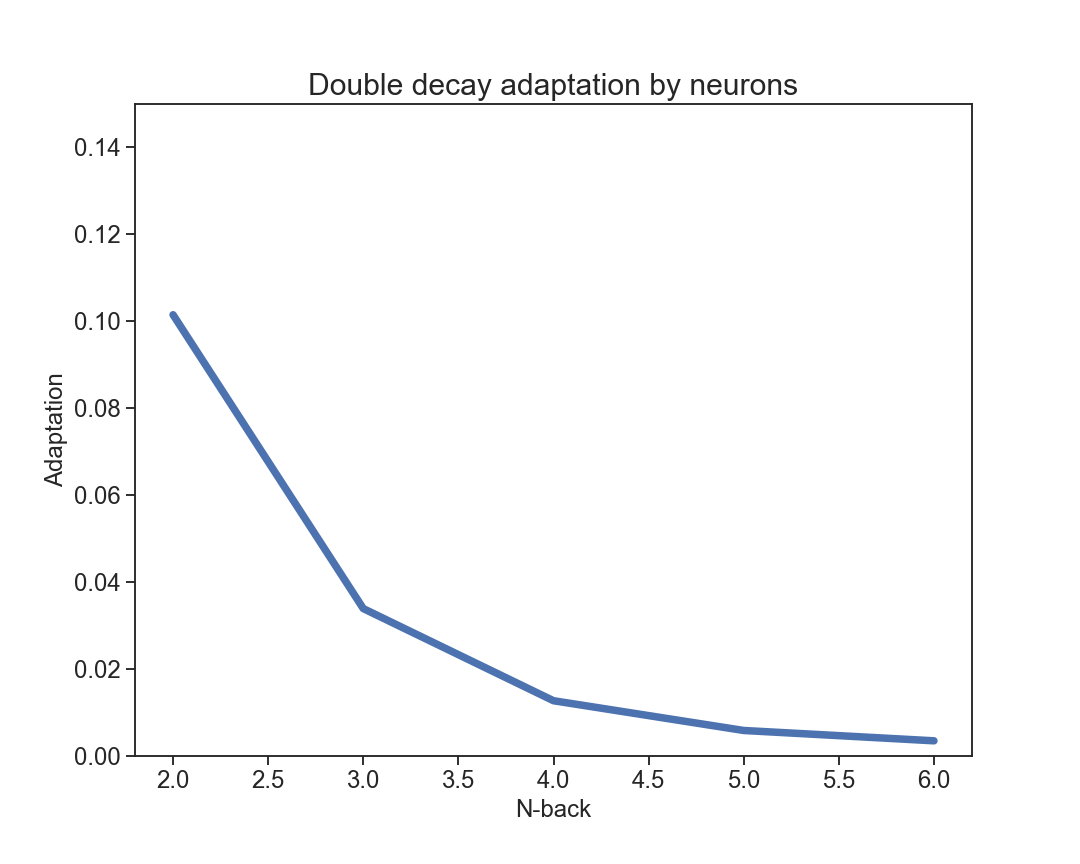

In [16]:
figsize(10, 8)
sns.set_theme(style="ticks")

# create lineplots for both tuning functions
g = sns.lineplot(x=x_decay[1:], 
                 y=np.diff(y_decay), 
                 lw=5)

plt.title("Double decay adaptation by neurons", fontsize=20)
plt.ylabel("Adaptation", fontsize=16)
plt.xlabel("N-back", fontsize=16)
plt.axhline(1, color='grey', lw=2.5, ls='--')
plt.ylim([0, 0.15])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

In [ ]:
y_decay

In [ ]:
# look at ways to get the decay as a step function
# take der of both slow and fast functions
# use der. to make step function

In [ ]:
[''] * len(ax2.get_yticklabels())

In [ ]:
plt.plot(stim_train[:20])

# animated lineplot from stim train underneed

In [ ]:
fig = plt.figure()

In [ ]:
fig (ax1, ax2) = plt.subplots(2, figsize=(12, 8))

tun, = ax.plot(x)

def animate(B):
    


In [ ]:
adapt_total, adapt_matrix = Stim_adaptation(stim_train, y_decay)

adapt_total

In [ ]:
adapt_total, adapt_matrix = Stim_adaptation(stim_train, y_decay)

adapt_total

In [ ]:
adapt_matrix = np.zeros([len(stim_train), len(y_decay)])   # make empty matrix of train length by number of N-backs 
total_adapt = np.zeros(len(stim_train))                    # make empty array of stim train length

# loop over stimuli starting at N+1
for stim in range(1, len(stim_train)):
    
    # create a temp nback array to indicate adoptation
    n_back_array = np.zeros(len(y_decay))
    
    # for the first few stimulus (to avoid wrapping)
    if stim <= len(y_decay): 
        # populate Nback array with boolean, starting from right most (n-1)
        n_back_array[:stim] = (stim_train[:stim] == stim_train[stim]).astype(int)[::-1]

    else: 
        # populate Nback array with boolean, starting from right most (n-1)
        n_back_array[:] = (stim_train[stim-len(y_decay):stim] == stim_train[stim]).astype(int)[::-1]

    # populate our return arrays
    n_back_array *= y_decay                                      # multiply boolean array by decay array (1 encoding) 
    adapt_matrix[stim,:] = n_back_array                          # full length by N-backs array
    if n_back_array.sum() > 0: total_adapt[stim] = np.prod(n_back_array[n_back_array > 0])  # multiplicative adaptation
    else: total_adapt[stim]: 0.0

In [ ]:
total_adapt

In [ ]:
adapt_matrix

In [ ]:
n_back_array = np.zeros(len(y_decay))
n_back_array

stim = 6

n_back_array[:stim] = (stim_train[:stim] == stim_train[stim]).astype(int)[::-1]
n_back_array *= y_decay
np.prod(n_back_array[n_back_array > 0]) # multiplicative adaptation 

In [ ]:
n_back_array

In [ ]:
stim_train[:stim],stim_train[stim]

In [ ]:
(stim_train[:stim] == stim_train[stim]).astype(int)


# (stim, stim_train[stim], stim_train[:stim])
# y_decay

In [ ]:
stim_train[stim-len(y_decay):stim]

In [ ]:
y_decay

In [ ]:
y_decay[::-1]

In [ ]:
# check if the same as current and create boolean array
abc = (stim_train[stim-len(y_decay):stim] == stim_train[stim]).astype(int)

# 
abc * y_decay

In [ ]:
# SHORT TERM PLAN

# C. INSTEAD MODEL ADAPTATION AS A DECAYING FUNCTION (SEE PICTURE PHONE)
#   - CALCULATE AMOUNT OF DECAY BY DIFFERENCE DOUBLE EXP DECAY FUNCTION
# D. USE A SEQUENCE OF OTHER SOUNDS ON THE TWO NEURONS TO GET AN INTUATION OF THEIR DYNAMICS 
#    (LESS ACTIVATION, SO LESS ADAPTATION)
# E. CREATE A ACTIVITY GRID (X BY X) --> NEURONS IN THIS GRID HAVE OWN TUNING FUNCTION
#    WE CAN THEN USE THE GAUSSIAN FUNCTION (ADJUSTED FOR JUST ONE X) TO CALCULATE ACTIVITY FOR A RANDOM TRAIN
#   - DISPLAY THIS IN A HEAT MAP (ANIMATED?), GIVING A TONOTONIC MAP WITH LONG TRACE
# F. OTHER KINDS OF ADAPTATION, SHAPENING/BROADENING OR SHIFTING

# LONG TEMP PLANS:
# 1. ADD NOISE TO THE GAUSSIAN FUNCTIONS
# 1b. THIS NOISE SHOULD BE ACTIVATION DEPENDENT (HIGHER ACTIVATION, MORE VARIABLITY)
# 1c. THEN THE PLOTS CAN HAVE A 95CI (BOOTSTRAPPED)
# 2. WRAP FUNCTIONS IN .PY FILE AND LOAD FROM THERE